In [0]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.7MB/s 


In [0]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('/content/Eminescu.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 816696


In [0]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

i de zapada si cu parul lucitor
Si mai goala este-n somnu-i, numai bolta nalta, sura
A ferestei este rece si simtirea nu o fura,
Dar de panz-acoperita-i cu un colb de piatra scumpa.
S-apropie-ncet voin


In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size) # We use embeddings instead of one-hot encoding
        self.gru = nn.RNN(hidden_size, hidden_size, n_layers) # RNN network 
        self.decoder = nn.Linear(hidden_size, output_size) # Linear output layer
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size) # we initialize the first hidden stat with zeros

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [0]:

random_training_set()

(tensor([35, 18, 29, 10, 73, 94, 13, 18, 23, 94, 23, 24, 27, 24, 18, 96, 54, 74,
         10, 30, 94, 23, 10, 28, 12, 30, 29, 94, 31, 18, 14, 27, 22, 18, 18, 94,
         23, 14, 16, 27, 30, 21, 30, 18, 94, 12, 10, 13, 10, 31, 27, 30, 77, 96,
         50, 10, 22, 14, 23, 18, 18, 75, 96, 54, 25, 27, 14, 94, 10, 74, 21, 94,
         11, 10, 29, 19, 24, 12, 24, 27, 18, 94, 25, 10, 23, 10, 94, 28, 18, 74,
         23, 94, 22, 24, 10, 27, 29, 14, 96, 49, 14, 74, 10, 22, 94, 23, 10, 28,
         12, 30, 29, 94, 23, 24, 18, 73, 94, 13, 30, 25, 10, 94, 24, 27, 13, 18,
         23, 94, 13, 18, 31, 18, 23, 73, 96, 41, 10, 12, 30, 29, 18, 94, 12, 10,
         94, 28, 10, 74, 28, 18, 94, 25, 14, 29, 27, 14, 10, 12, 10, 94, 39, 30,
         22, 23, 14, 35, 14, 30, 21, 96, 37, 10, 29, 27, 10, 23, 94, 12, 30, 94,
         12, 24, 22, 18, 12, 10, 74, 23, 14, 94, 23, 14, 25, 30, 29, 18, 23, 29,
         10, 73]),
 tensor([18, 29, 10, 73, 94, 13, 18, 23, 94, 23, 24, 27, 24, 18, 96, 54, 74, 10,
         

In [0]:
# Temperature is a variable that controls the randomness of the selection process from the multinomial distribution

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [0]:
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.01

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 12s (100 0%) 2.5157]
Whele, antud arimi ni loa miima detufistoa Dine-ma cuma
Nu rose slastisa
in azunte inintiu lec-asuria  

 25s (200 1%) 2.5822]
Wharmi dumi, a ca imau!.... la si marice cjac ca de va de sa scari vii ai aseloc;
		 sceti,
In cu mama 

 37s (300 1%) 2.4062]
Whari a ade elosnica de si supind sa sa arelul,
Un ui sa-nterinor dastrareiea stu-mnapea
S-a amai
Be c 

 50s (400 2%) 2.7142]
Whi mand cace pe oseca tin rina coara inda-nd fienfaundul Ru iorii orivestre land morinte alcea mauna  

 3s (500 2%) 2.6041]
Wha gotou la s-ane ta sta Stepa i-u sa el straguri cecereruri-mi intort-i gazicoare inziu ta-l nimare  

 15s (600 3%) 2.2348]
Whe zandi-n osti minta -range manazin aca saun bobi derara,
 clur ca presti. Mu vorunte pitie si - Ena 

 28s (700 3%) 2.1884]
Whinte-ntuncora amuti a ce ralui albelul azazi alte intruntica ama catoste nu al de trate cu-apuca isn 

 41s (800 4%) 2.2171]
Whrii ei un cuce nu auri,
Cu pe stel extrea nans napurii toat.


- nu cu zacine-i tin apoa

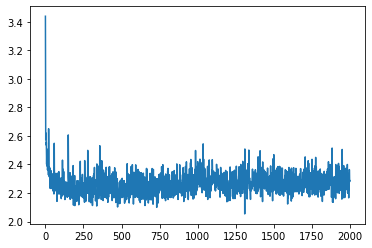

In [0]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [0]:
print(evaluate('Pe sufletele ', 200, temperature=0.5))

Pe sufletele din inta vare
				
Cuma-i ducea si-n in data-mi de in lama de trinde sa-n durini supind ramanti de devand,
Si si viata de subiti veriu de plepta de-amande sa la mistii de-aleage,
Carate
Si si ale de-i


In [0]:
print(evaluate('inima', 200, temperature=0.2))

inima de de si si si la in de si si vini de si si viste de de-atata de si vistra de si sa veste de-amanderi de ca la si de vista de de de si viste de nimpa de de de de viste de viste de vine de ca de si si


In [0]:
print(evaluate('inima', 200, temperature=1))

inima-i catela,
Na ce lui a luti sufle,
Ci nimpratata los.


Ce de nimpunea, deri,
Mira-ii n-iti Pupul inarisie-i
E aurimpriii insinderintuntiei puinat., da underentare-n jalt.


	Cimpate, snip
Ca-amaua-ng
